In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

# Loading the dataset in a matrix X

In [3]:
"""
X is stored in a h5 file. 
There are 4400 different samples. 
Each sample is made of 8 concatenated signals.
Each signal is 90 sec window, sampled with a 100Hz frequency (ie 9000 values.)
(so size of one sample is 9000*8= 72000 values)


- 0: sample index
- 1: subject index
- 2 to 9001: Abdominal belt
- 9002 to 18001: Airflow
- 18002 to 27001: PPG (Photoplethysmogram)
- 27002 to 36001: Thoracic belt
- 36002 to 45001: Snoring indicator
- 45002 to 54001: SPO2
- 54002 to 63001: C4-A1
- 63002 to 72001:O2-A1
"""

X = h5py.File('X_train.h5', 'r')  
print(X.keys())

X = X['data'][:] # convert h5 file to a numpy array
X = X[:,2:] #remove patient id and index (useless)
X.shape

<KeysViewHDF5 ['data']>


(4400, 72000)

# Visualize the sleeping apneas

In [4]:
# y is, for each of the 4400 samples,  a boolean mask of length 90 sec. "1" means sleeping apnea. "0" means normal sleep

y = pd.read_csv('y_train.csv')
y = y.iloc[:,1:] #remove the index column (useless)
y.shape

(4400, 90)

<AxesSubplot:>

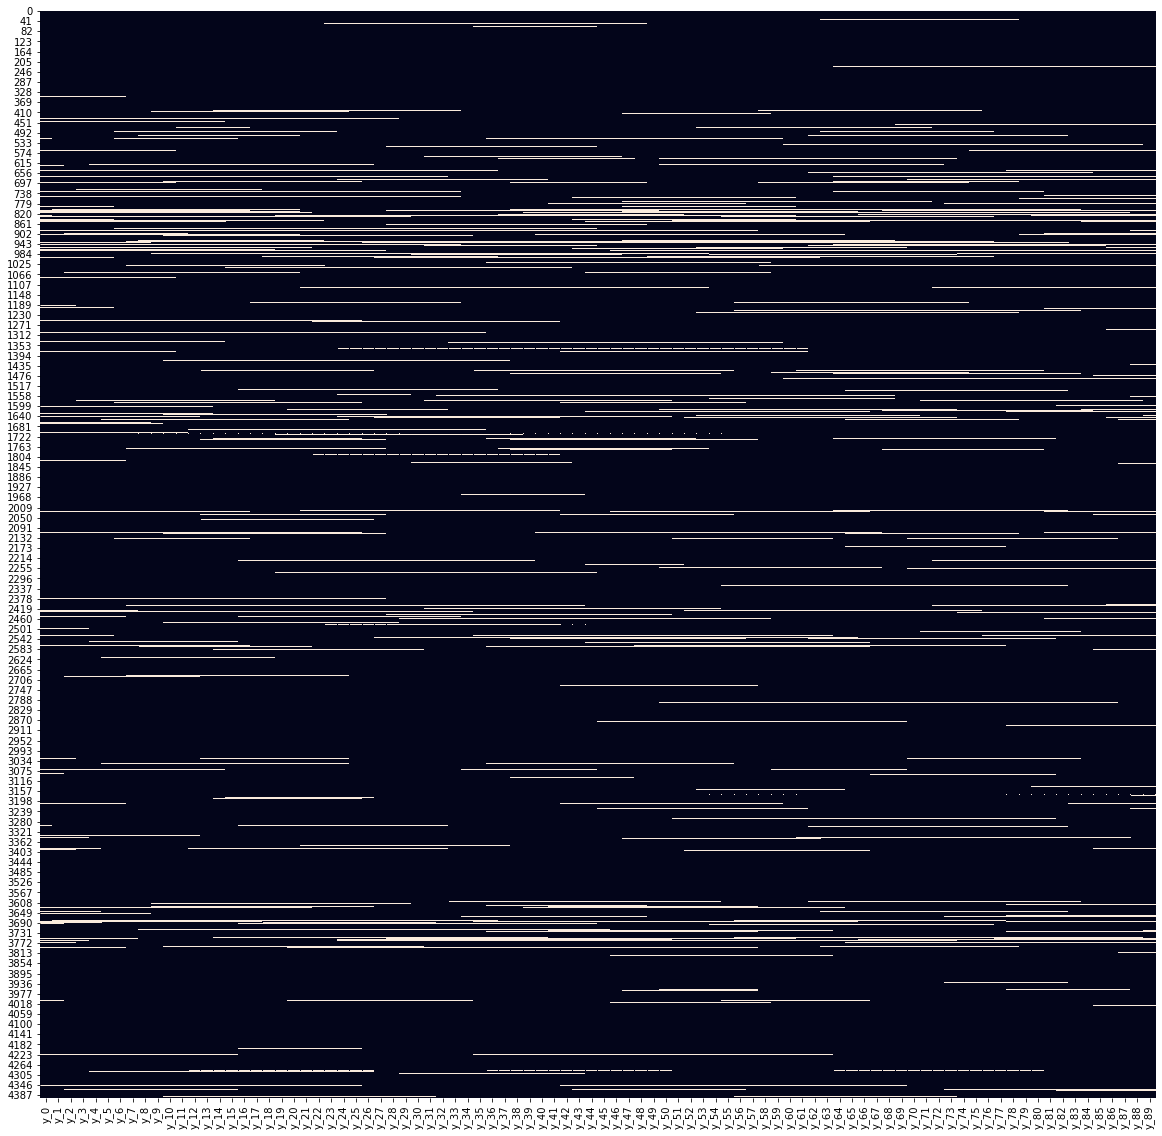

In [5]:
import seaborn as sns               #visualising sleeping apneas spread for 4400 samples

plt.figure(figsize=(20,20))
sns.heatmap(y,cbar=False) 

# Visualize the signals for one patient

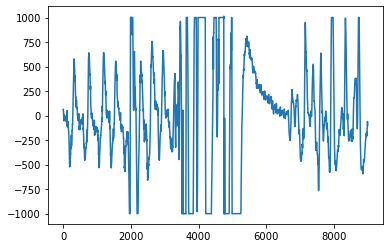

In [6]:
plt.figure(figsize=(20,5))
plt.plot(X[0,0:9000])

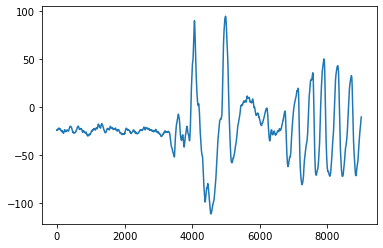

In [7]:
plt.plot(X[0,9000:18000])

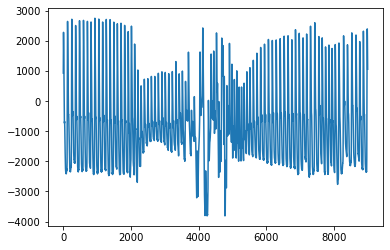

In [8]:
plt.plot(X[0,18000:27000])

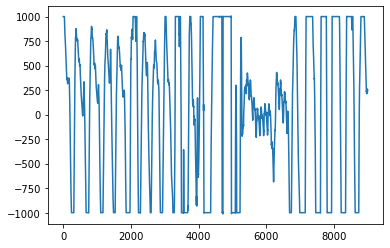

In [9]:
plt.plot(X[0,27000:36000])

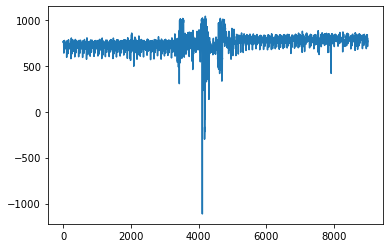

In [10]:
plt.plot(X[0,36000:45000])

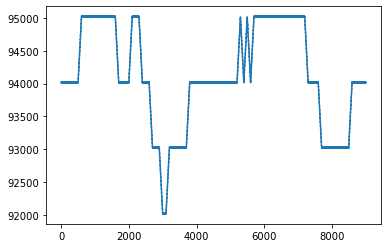

In [11]:
plt.plot(X[0,45000:54000])

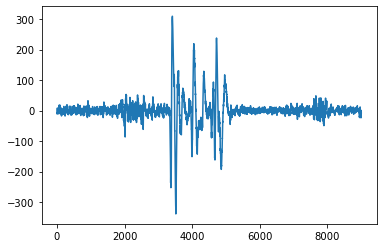

In [12]:
plt.plot(X[0,54000:63000])

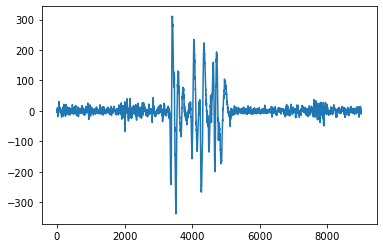

In [13]:
plt.plot(X[0,63000:72000])

# Reshaping X for the 1d convolutional network : size (4400, 9000, 8) to preserve temporal structure

In [14]:
X_reshape = np.zeros( (4400, 9000, 8) )

for i in range(4400):
    temp = X[i,:].reshape(8, 9000)
    X_reshape[i,:,:] = temp.T

X_reshape.shape

(4400, 9000, 8)

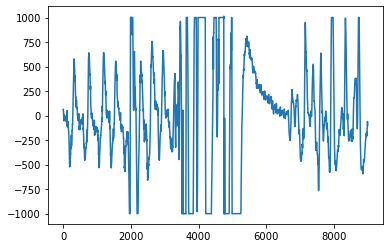

In [15]:
plt.plot(X_reshape[0,:,0])

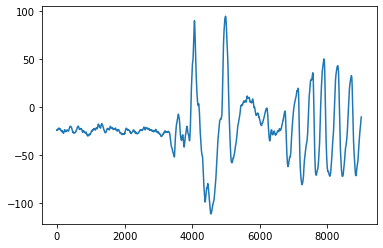

In [16]:
plt.plot(X_reshape[0,:,1])

# Normalizing each row of each sample. The 8 signals differ in range.

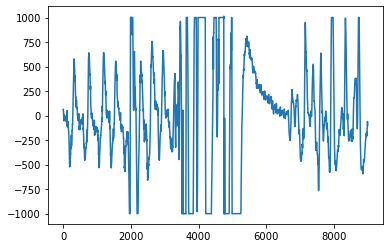

In [20]:
"""BEFORE NORMALIZATION """
plt.plot(X_reshape[0,:,0])

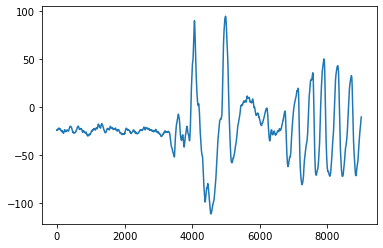

In [18]:
plt.plot(X_reshape[0,:,1])

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 

scaler.fit(X_reshape[0,:,:])

X_norm = np.zeros( (4400, 9000, 8) )

for i in range (4400) :
    X_norm[i,:,:] = scaler.transform( X_reshape[i,:,:] )  #scales the matrix in columns and that's we want

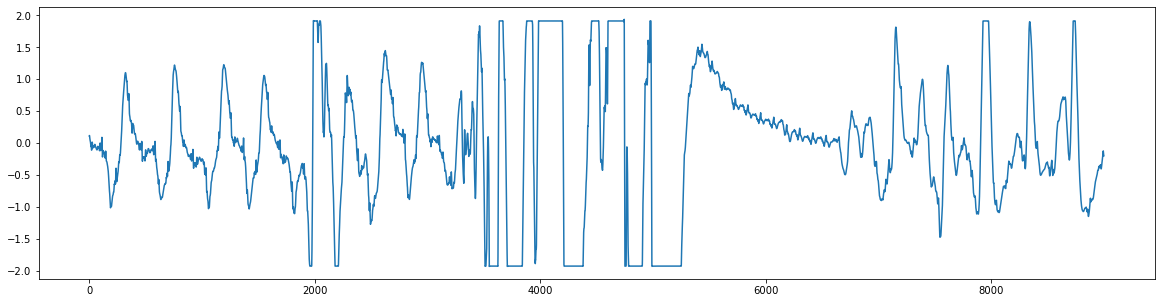

In [22]:
""" AFTER NORMALIZATION """
plt.figure(figsize=(20,5))
plt.plot(X_norm[0,:,0])


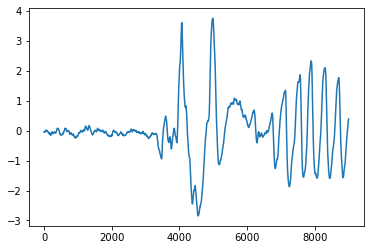

In [23]:
plt.plot(X_norm[0,:,1])

# Train and test.

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X_norm, y, test_size=0.2, random_state=0 )  #splitting the dataset between train set and test set.
print( X_train.shape )
print( y_train.shape )
print( X_test.shape )
print( y_test.shape )

(3520, 9000, 8)
(3520, 90)
(880, 9000, 8)
(880, 90)


# Building the network

In [25]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([    
    
#BASE                                          
    layers.Conv1D(filters=6, kernel_size=3 , strides=1 , padding='same',  input_shape=[ 9000, 8]), 
    layers.Activation('relu'),
    layers.MaxPooling1D(pool_size=10, strides =10 ),
    
    layers.Conv1D(filters=16, kernel_size=3 , strides=1 , padding='same'),  
    layers.Activation('relu'),
    layers.MaxPooling1D(pool_size=10, strides =10 ),

#HEAD
    layers.Flatten(), 
    layers.Dense(360, activation='relu'),
    layers.Dense(180, activation='relu'),
    layers.Dense(90, activation='sigmoid') 
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 9000, 6)           150       
_________________________________________________________________
activation (Activation)      (None, 9000, 6)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 900, 6)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 900, 16)           304       
_________________________________________________________________
activation_1 (Activation)    (None, 900, 16)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 90, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1440)              0

In [26]:
# cost function : cross entropy on a vector(and for 4400 samples?)

model.compile( optimizer ='adam', loss ='binary_crossentropy', metrics =['binary_accuracy'] ) 


In [28]:
#fitting the network

record = model.fit(
    X_train, y_train,
    validation_data =( X_test, y_test ),
    batch_size=50,
    epochs=5,
)

Epoch 1/5
71/71 [==============================] - 8s 109ms/step - loss: 0.2180 - binary_accuracy: 0.9304 - val_loss: 0.2323 - val_binary_accuracy: 0.9321
Epoch 2/5
71/71 [==============================] - 7s 104ms/step - loss: 0.2044 - binary_accuracy: 0.9319 - val_loss: 0.2266 - val_binary_accuracy: 0.9297
Epoch 3/5
71/71 [==============================] - 8s 107ms/step - loss: 0.1927 - binary_accuracy: 0.9341 - val_loss: 0.2203 - val_binary_accuracy: 0.9342
Epoch 4/5
71/71 [==============================] - 8s 107ms/step - loss: 0.1694 - binary_accuracy: 0.9400 - val_loss: 0.2292 - val_binary_accuracy: 0.9351
Epoch 5/5
71/71 [==============================] - 7s 98ms/step - loss: 0.1546 - binary_accuracy: 0.9456 - val_loss: 0.2058 - val_binary_accuracy: 0.9343


Best Validation Loss: 0.2057756781578064Best Validation accuracy: 0.9296717047691345


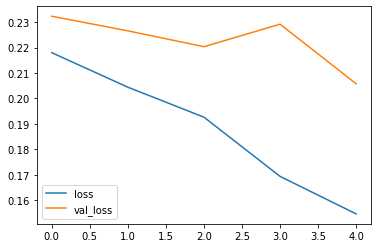

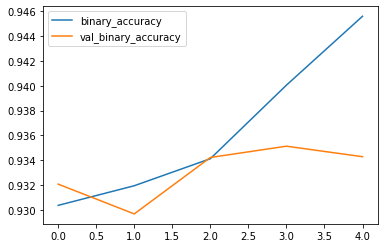

In [29]:
# plotting learning curves

history_df = pd.DataFrame( record.history )

history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot() 

print(("Best Validation Loss: {}"  + "Best Validation accuracy: {}").format(history_df['val_loss'].min(), 
            history_df['val_binary_accuracy'].min()))

# Predictions

In [ ]:
X_norm[18:19,:,:].shape

In [ ]:
pred_example = model.predict( X_norm[18:19,:,:] )
print( pred_example.shape )
plt.plot(pred_example.T)

# Same preprocessing on X_true

In [30]:
X_true= h5py.File('X_test.h5', 'r') # loading X ground truth set
X_true=X_true['data'][:] 
X_true=X_true[:,2:]
X_true.shape

(4400, 72000)

In [31]:
X_true_reshape = np.zeros( (4400, 9000, 8) )

for i in range(4400):
    temp = X_true[i,:].reshape(8, 9000)
    X_true_reshape[i,:,:] = temp.T

X_true_reshape.shape


(4400, 9000, 8)

In [33]:
X_true_norm = np.zeros( (4400, 9000, 8) )

for i in range (4400) :
    X_true_norm[i,:,:] = scaler.transform( X_true_reshape[i,:,:] )

# Prediction for X_true

In [34]:
y_pred = model.predict( X_true_norm )  # our prediction
y_pred.shape

(4400, 90)

<AxesSubplot:>

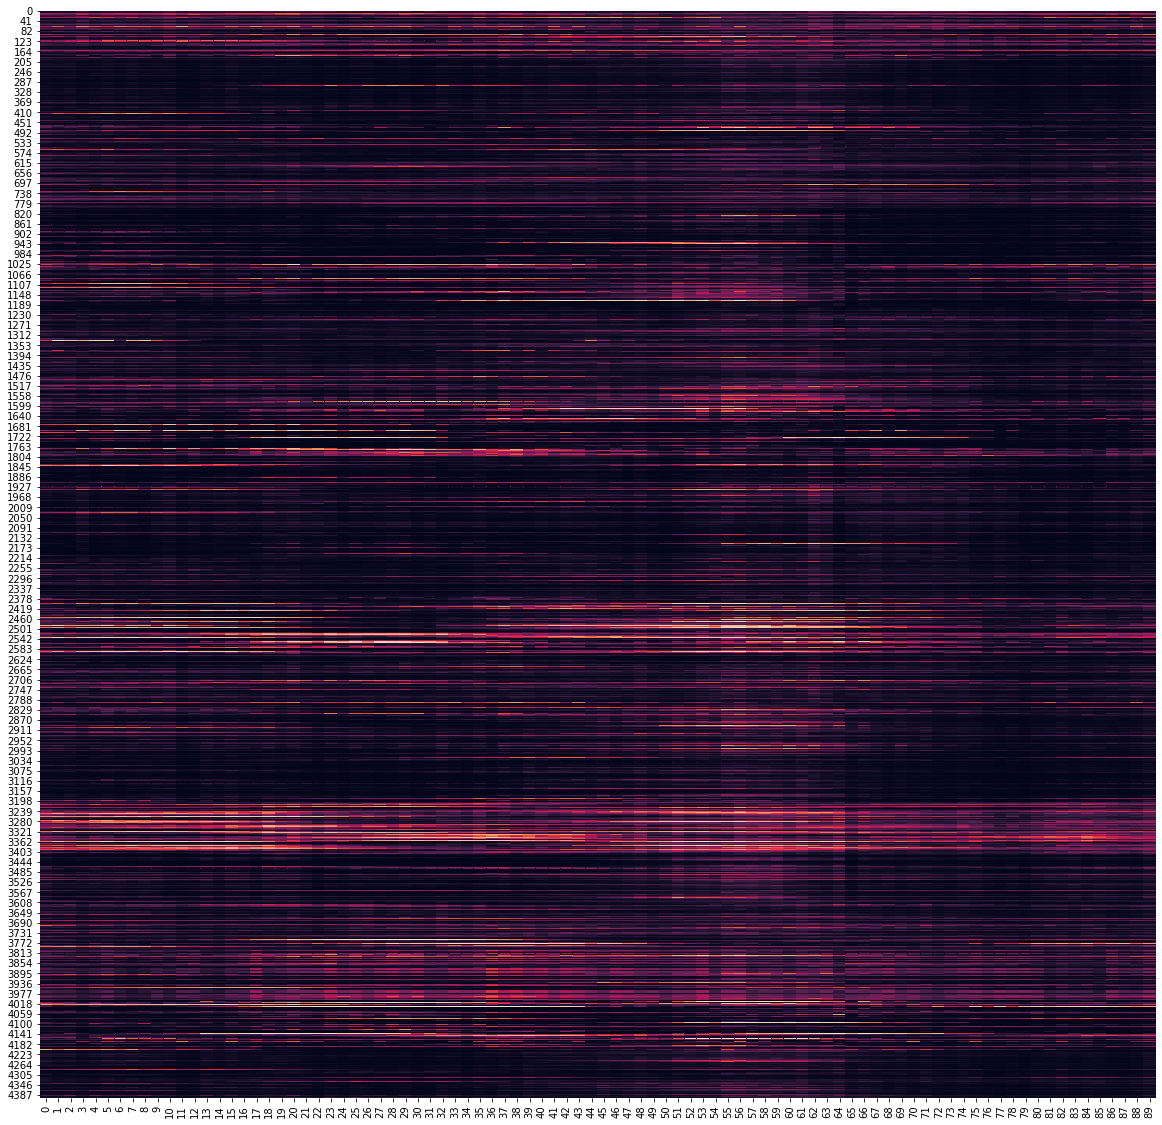

In [35]:
plt.figure(figsize=(20,20)) # visualizing the coherence of our prediction
sns.heatmap( y_pred, cbar=False)

# Output for the challenge & decision rule

In [36]:
y_submission = pd.read_csv('y_benchmark.csv') # excample of prediction
y_submission



,ID,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,...,y_80,y_81,y_82,y_83,y_84,y_85,y_86,y_87,y_88,y_89
0,4400,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4401,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4402,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,4403,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,4404,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4395,8795,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4396,8796,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4397,8797,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4398,8798,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
for i in range(y_pred.shape[0]):
    for j in range(y_pred.shape[1]):
        if y_pred[i,j]>0.5:          
            
            y_submission.iloc[i,j+1]=1
        else :
            y_submission.iloc[i,j+1]=0


<AxesSubplot:>

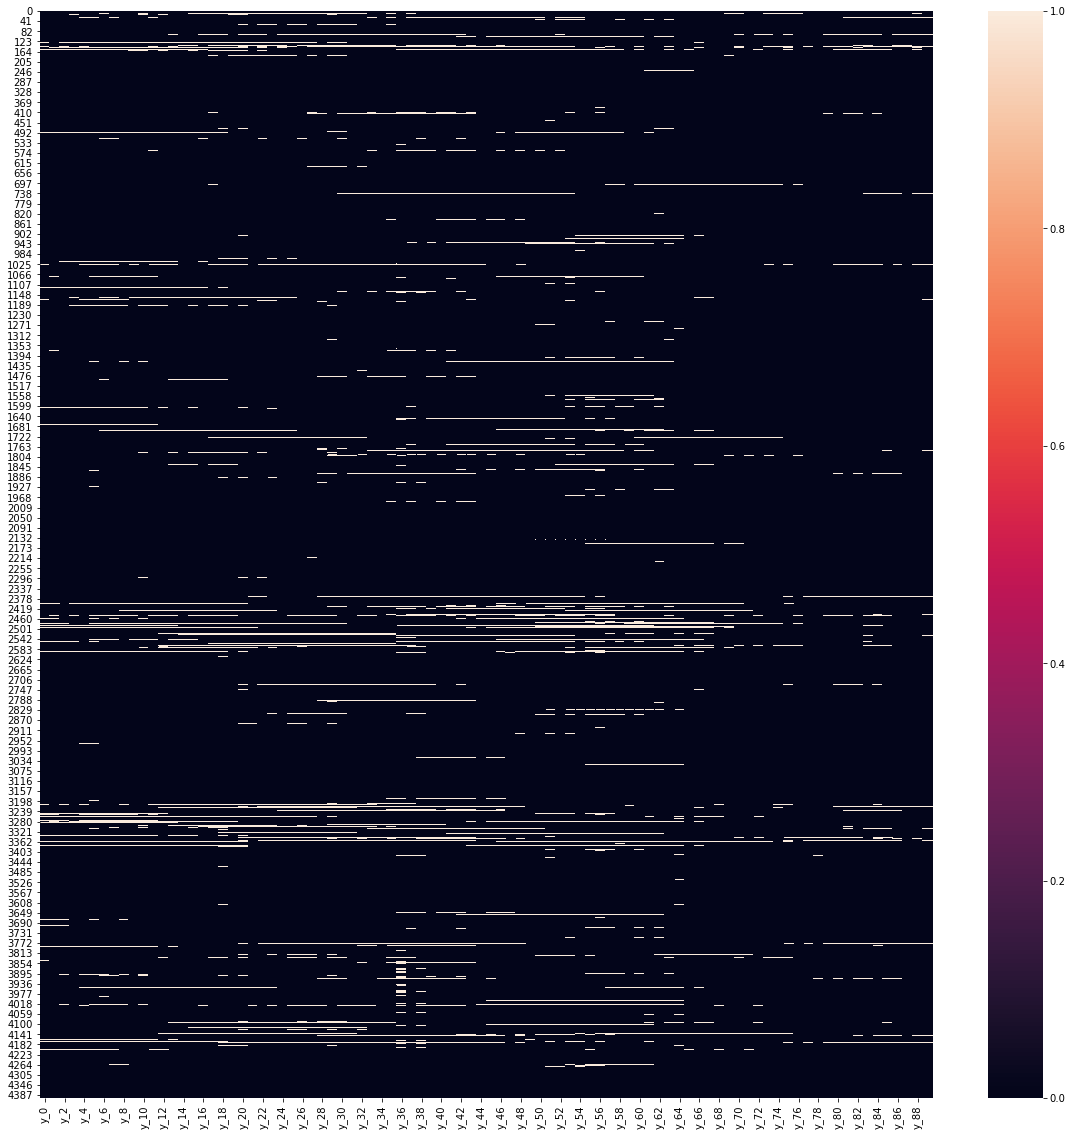

In [38]:
plt.figure(figsize=(20,20)) # visualizing the  prediction
sns.heatmap(y_submission.iloc[:,1:])

In [41]:
# export
y_submission.to_csv('essai_pred18_04.csv' ,index=False)

# ##########   PERSONNAL NOTES, DO NOT READ####################


In [ ]:
SIGNALS_NAME = [
    "AbdoBelt",
    "AirFlow",
    "PPG",
    "ThorBelt",
    "Snoring",
    "SPO2",
    "C4A1",
    "O2A1",
]


def extract_events_from_binary_mask(binary_mask, fs=1):
    binary_mask = np.array([0] + binary_mask.tolist() + [0])
    diff_data = np.diff(binary_mask)
    starts = np.where(diff_data == 1)[0] / fs
    ends = np.where(diff_data == -1)[0] / fs

    assert len(starts) == len(ends)
    events = []
    for i, _ in enumerate(starts):
        events += [(starts[i], ends[i])]

    return events


def visualize_signal_and_event(X, mask, signals_name=SIGNALS_NAME, signal_freq=100):
    n_signal = X.shape[0]
    fig, axs = plt.subplots(n_signal, sharex=True)
    events = extract_events_from_binary_mask(mask)
    for i in range(n_signal):
        axs[i].plot(np.arange(0, X[i].shape[0]) / signal_freq, X[i])
        axs[i].set_ylabel(signals_name[i])
        for elt in events:
            axs[i].axvspan(elt[0], elt[1], color='red', alpha=0.3)
    plt.xlim(0, X[0].shape[0]/ signal_freq)
    plt.show()


def visualise_index(idx, data_h5, masks, N_signals=8):
    x = data_h5['data'][idx, 2:]
    x = x.reshape(N_signals, -1)
    visualize_signal_and_event(x, np.array(masks[idx, 1:]))


if __name__ == "__main__":
    import h5py
    PATH_TO_TRAINING_DATA = "C:\\Users\\pierr\\REPERTOIRE_PROJETS_DATA\\DREEM_PROJECT\\X_train.h5"
    PATH_TO_TRAINING_TARGET = "C:\\Users\\pierr\\REPERTOIRE_PROJETS_DATA\\DREEM_PROJECT\\y_train.csv"
    h5_file = h5py.File(PATH_TO_TRAINING_DATA)
    mask = np.array(pd.read_csv(PATH_TO_TRAINING_TARGET))
    visualise_index(18, h5_file, mask)